In [124]:
files = "https://github.com/scoutog/Kobe-Bryant-Shot-Selection/raw/master/kobe-shots.zip" 
!rm -rf * && wget $files && unzip -o kobe-shots.zip

--2019-10-19 21:28:57--  https://github.com/scoutog/Kobe-Bryant-Shot-Selection/raw/master/kobe-shots.zip
Resolving github.com (github.com)... 192.30.253.112
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/scoutog/Kobe-Bryant-Shot-Selection/master/kobe-shots.zip [following]
--2019-10-19 21:28:57--  https://raw.githubusercontent.com/scoutog/Kobe-Bryant-Shot-Selection/master/kobe-shots.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 738206 (721K) [application/zip]
Saving to: ‘kobe-shots.zip’

kobe-shots.zip      100%[===================>] 720.90K  --.-KB/s    in 0.04s   

2019-10-19 21:28:57 (16.6 MB/s) - ‘kobe-shots.zip’ saved [738206/738206]

A

## Load in the data and do some exploratory data analysis

In [125]:
# Load the data here
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

data  = pd.read_csv("data.csv")

data.head(3)


,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3


In [126]:
print('Dim of data: ', data.shape)

Dim of data:  (30697, 25)


In [127]:
list(data.columns)

['action_type',
 'combined_shot_type',
 'game_event_id',
 'game_id',
 'lat',
 'loc_x',
 'loc_y',
 'lon',
 'minutes_remaining',
 'period',
 'playoffs',
 'season',
 'seconds_remaining',
 'shot_distance',
 'shot_made_flag',
 'shot_type',
 'shot_zone_area',
 'shot_zone_basic',
 'shot_zone_range',
 'team_id',
 'team_name',
 'game_date',
 'matchup',
 'opponent',
 'shot_id']

In [0]:
dropna =  data[pd.notnull(data['shot_made_flag'])]

###Understanding loc_x, loc_y, lat, and lon

Text(0.5, 1.0, 'lat and lon')

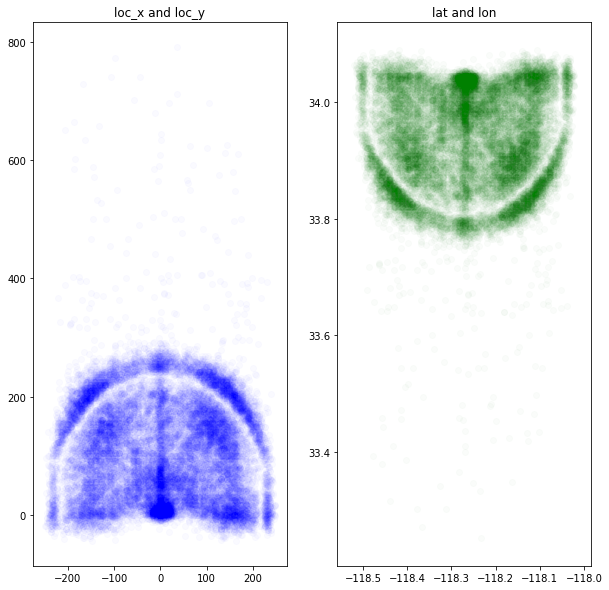

In [129]:
alpha = 0.02
plt.figure(figsize=(10,10))

# loc_x and loc_y
plt.subplot(121)
plt.scatter(dropna.loc_x, dropna.loc_y, color='blue', alpha=.02)
plt.title('loc_x and loc_y')

# lat and lon
plt.subplot(122)
plt.scatter(dropna.lon, dropna.lat, color='green', alpha=.02)
plt.title('lat and lon')

###Using this data to create variables angle and dist i.e. polar coordinates. This allows us to get rid of many variables

In [130]:
data['dist'] = np.sqrt(data['loc_x']**2 + data['loc_y']**2)

loc_x_zero=data['loc_x'] == 0
data['angle'] = np.array([0]*len(data))
data['angle'][~loc_x_zero] = np.arctan(data['loc_y'][~loc_x_zero] / data['loc_x'][~loc_x_zero])
data['angle'][loc_x_zero] = np.pi / 2 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


###Explore action_type, combined_shot_type, and shot_type

#####action_type is very specific 

#####combined_shot_type tells us what kind of shot it is

#####shot_type tells us if its for 2 or 3

In [131]:
print(dropna.action_type.unique())

['Jump Shot' 'Driving Dunk Shot' 'Layup Shot' 'Running Jump Shot'
 'Reverse Dunk Shot' 'Slam Dunk Shot' 'Driving Layup Shot'
 'Turnaround Jump Shot' 'Reverse Layup Shot' 'Tip Shot'
 'Running Hook Shot' 'Alley Oop Dunk Shot' 'Dunk Shot'
 'Alley Oop Layup shot' 'Running Dunk Shot' 'Driving Finger Roll Shot'
 'Running Layup Shot' 'Finger Roll Shot' 'Fadeaway Jump Shot'
 'Follow Up Dunk Shot' 'Hook Shot' 'Turnaround Hook Shot' 'Jump Hook Shot'
 'Running Finger Roll Shot' 'Jump Bank Shot' 'Turnaround Finger Roll Shot'
 'Hook Bank Shot' 'Driving Hook Shot' 'Running Tip Shot'
 'Running Reverse Layup Shot' 'Driving Finger Roll Layup Shot'
 'Fadeaway Bank shot' 'Pullup Jump shot' 'Finger Roll Layup Shot'
 'Turnaround Fadeaway shot' 'Driving Reverse Layup Shot'
 'Driving Slam Dunk Shot' 'Step Back Jump shot' 'Turnaround Bank shot'
 'Reverse Slam Dunk Shot' 'Floating Jump shot' 'Putback Slam Dunk Shot'
 'Running Bank shot' 'Driving Bank shot' 'Driving Jump shot'
 'Putback Layup Shot' 'Putback Dun

In [132]:
print(dropna.combined_shot_type.unique())

['Jump Shot' 'Dunk' 'Layup' 'Tip Shot' 'Hook Shot' 'Bank Shot']


In [133]:
print(dropna.shot_type.unique())

['2PT Field Goal' '3PT Field Goal']


### Combining minutes remaining and seconds remaining to form one variable 'remaining_time'



In [0]:
data['remaining_time'] = data['minutes_remaining'] * 60 + data['seconds_remaining']

###Season: If season is 2015-16 change it so its just 2015

In [135]:
dropna['season'].unique()

array(['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '1996-97', '1997-98',
       '1998-99', '1999-00'], dtype=object)

In [136]:
data['season'] = data['season'].apply(lambda x: int(x.split('-')[0]))
data['season'].unique()

array([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010,
       2011, 2012, 2013, 2014, 2015, 1996, 1997, 1998, 1999])

###Look at team_id and team_name (NOTE that Kobe played his whole career for the Lakers)

In [137]:
print(dropna['team_id'].unique())
print(dropna['team_name'].unique())

[1610612747]
['Los Angeles Lakers']


###Look at opponent and matchup (REDUNDANT)

In [138]:
pd.DataFrame({'matchup':dropna.matchup, 'opponent':dropna.opponent}).head()

,matchup,opponent
1,LAL @ POR,POR
2,LAL @ POR,POR
3,LAL @ POR,POR
4,LAL @ POR,POR
5,LAL @ POR,POR


###Drop unnecessary variables

In [0]:
drops = ['shot_id', 'team_id', 'team_name', 'shot_zone_area', 'shot_zone_range',
         'shot_zone_basic', 'matchup', 'lon', 'lat', 'seconds_remaining', 
         'minutes_remaining', 'shot_distance', 'loc_x', 'loc_y', 
         'game_event_id', 'game_id', 'game_date']

for i in drops:
    data = data.drop(i, 1)

In [140]:
data.head()

,action_type,combined_shot_type,period,playoffs,season,shot_made_flag,shot_type,opponent,dist,angle,remaining_time
0,Jump Shot,Jump Shot,1,0,2000,NaN,2PT Field Goal,POR,181.859836,0.407058,627
1,Jump Shot,Jump Shot,1,0,2000,0.0,2PT Field Goal,POR,157.000000,-0.000000,622
2,Jump Shot,Jump Shot,1,0,2000,1.0,2PT Field Goal,POR,168.600119,-0.928481,465
3,Jump Shot,Jump Shot,1,0,2000,0.0,2PT Field Goal,POR,222.865430,0.903063,412
4,Driving Dunk Shot,Dunk,2,0,2000,1.0,2PT Field Goal,POR,0.000000,1.570796,379


###Make dummy variables from categorical data

In [0]:
features_data = data[['action_type', 'combined_shot_type', 'shot_type', 
                      'opponent', 'period', 'season']]

for i in features_data:
    data = pd.concat([data, pd.get_dummies(data[i], prefix=i)], 1)
    data = data.drop(i, 1)

In [142]:
data.head()

,playoffs,shot_made_flag,dist,angle,remaining_time,action_type_Alley Oop Dunk Shot,action_type_Alley Oop Layup shot,action_type_Cutting Finger Roll Layup Shot,action_type_Cutting Layup Shot,action_type_Driving Bank shot,action_type_Driving Dunk Shot,action_type_Driving Finger Roll Layup Shot,action_type_Driving Finger Roll Shot,action_type_Driving Floating Bank Jump Shot,action_type_Driving Floating Jump Shot,action_type_Driving Hook Shot,action_type_Driving Jump shot,action_type_Driving Layup Shot,action_type_Driving Reverse Layup Shot,action_type_Driving Slam Dunk Shot,action_type_Dunk Shot,action_type_Fadeaway Bank shot,action_type_Fadeaway Jump Shot,action_type_Finger Roll Layup Shot,action_type_Finger Roll Shot,action_type_Floating Jump shot,action_type_Follow Up Dunk Shot,action_type_Hook Bank Shot,action_type_Hook Shot,action_type_Jump Bank Shot,action_type_Jump Hook Shot,action_type_Jump Shot,action_type_Layup Shot,action_type_Pullup Bank shot,action_type_Pullup Jump shot,action_type_Putback Dunk Shot,action_type_Putback Layup Shot,action_type_Putback Slam Dunk Shot,action_type_Reverse Dunk Shot,action_type_Reverse Layup Shot,...,opponent_NYK,opponent_OKC,opponent_ORL,opponent_PHI,opponent_PHX,opponent_POR,opponent_SAC,opponent_SAS,opponent_SEA,opponent_TOR,opponent_UTA,opponent_VAN,opponent_WAS,period_1,period_2,period_3,period_4,period_5,period_6,period_7,season_1996,season_1997,season_1998,season_1999,season_2000,season_2001,season_2002,season_2003,season_2004,season_2005,season_2006,season_2007,season_2008,season_2009,season_2010,season_2011,season_2012,season_2013,season_2014,season_2015
0,0,NaN,181.859836,0.407058,627,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0.0,157.000000,-0.000000,622,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,1.0,168.600119,-0.928481,465,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0.0,222.865430,0.903063,412,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,1.0,0.000000,1.570796,379,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


###Separate training, target, submission

In [0]:
temp = data[pd.notnull(data['shot_made_flag'])]
submission = data[pd.isnull(data['shot_made_flag'])]
submission = submission.drop('shot_made_flag',1)

In [0]:
train = temp.drop('shot_made_flag',1)
y = temp['shot_made_flag']

###Looking at angle and distance. Innovative way to display place on court and get rid of 6 other columns

In [145]:
pd.DataFrame({'angle':train.angle, 'dist':train.dist}).head()

,angle,dist
1,-0.000000,157.000000
2,-0.928481,168.600119
3,0.903063,222.865430
4,1.570796,0.000000
5,0.075717,145.416643


#Making the Model

In [0]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators=40,max_depth=20)
classifier.fit(train, y)
pred = classifier.predict(submission)

from sklearn import metrics
#train_accuracy = metrics.accuracy_score(y,submission)

In [0]:
#from sklearn.model_selection import train_test_split


#train_X, val_X, train_y, val_y = train_test_split(train, y, 
#                                                    train_size=0.8,
#                                                    test_size=0.2,
#                                                    random_state=100)

###KNeighbors with changes

In [0]:
#classifier1 = KNeighborsClassifier(n_neighbors=1)
#classifier1.fit(train_X, train_y)
 
#knn1_val_y = classifier1.predict(val_X)
#knn1_val_accuracy = metrics.accuracy_score(val_y, knn1_val_y)

#print("New Val Accuracy: ", knn1_val_accuracy)
#print('')


#classifier2 = KNeighborsClassifier(n_neighbors=1)
#classifier2.fit(train_X, train_y)
 
#knn1_train_y = classifier2.predict(train_X)
#knn1_train_accuracy = metrics.accuracy_score(train_y, knn1_train_y)
#print("New Train Accuracy: ", knn1_train_accuracy)

#Submission

In [0]:
submit = pd.read_csv("sample_submission.csv")
submit['shot_made_flag'] = pred
submit.to_csv('final_submission.csv',index=False)

from google.colab import files
#files.download('final_submission.csv')